## Simulation of alpha test

Functions in order

   * func main_simulation_MC
   * func estimations
   * func bootstrap
   * func matrix_completion
   * func BH_procedure
   * func calculate_FDP_FDN

In [1]:
# load in necessary packages

import pandas as pd
import numpy as np
from scipy.io import loadmat, savemat
import scipy.stats as stats
from scipy.linalg import fractional_matrix_power as mpower

from numpy import diag, sqrt, sort, argsort, log, isnan, var, std, nanmean
from numpy.random import randn, choice, random
from numpy.linalg import norm, inv, lstsq, svd, eig
from numpy.matlib import repmat

import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# define the function for main simulation body

def main_simulation_MC (p1, p2, N, T):
    
    '''
    
    This function is the main body of simulation
    
    Input:
    
        p1         : p value for first normal dist
        p2         : p value for second normal dist
        N          : number of funds
        T          : number of time points
    
    Output: 
        
        output     : a dictionary storing all variable values
        Result.mat : .mat file storing results
    
    '''

    # import the hfparams.pkl

    pkl_file = open('hfparams.pkl', 'rb')
    param = pickle.load(pkl_file)
    pkl_file.close()

    Mc     =      1000 # number of MCs
    B      =      500  # number of Boostrap samples
    K      =      4    # mumber of observed factors
    r      =      1    # num of latent factors
    KK     =      K+r  # total num factors

    G      =      param['factorscov'] # cov of factors

    # Initilization
    
    alpha        = np.zeros([N,Mc])
    
    test_B1      = np.zeros([N,Mc])
    test_BH1     = np.zeros([N,Mc])
    
    test_B2      = np.zeros([N,Mc])
    test_BH2     = np.zeros([N,Mc])

    test_B3      = np.zeros([N,Mc])
    test_BH3     = np.zeros([N,Mc])

    test_B4      = np.zeros([N,Mc])
    test_BH4     = np.zeros([N,Mc])

    test_B5      = np.zeros([N,Mc])
    test_BH5     = np.zeros([N,Mc])
    
    test_B6      = np.zeros([N,Mc])
    test_BH6     = np.zeros([N,Mc])
    
    alpha_est_B1 = np.zeros([N,Mc])
    alpha_est_B2 = np.zeros([N,Mc])
    alpha_est_B3 = np.zeros([N,Mc])
    alpha_est_B4 = np.zeros([N,Mc])
    alpha_est_B5 = np.zeros([N,Mc])
    alpha_est_B6 = np.zeros([N,Mc])

    se_B1        = np.zeros([N,Mc])
    se_B2        = np.zeros([N,Mc])
    se_B3        = np.zeros([N,Mc])
    se_B4        = np.zeros([N,Mc])
    se_B5        = np.zeros([N,Mc])
    se_B6        = np.zeros([N,Mc])

    p_B1         = np.zeros([N,Mc])
    p_B2         = np.zeros([N,Mc])
    p_B3         = np.zeros([N,Mc])
    p_B4         = np.zeros([N,Mc])
    p_B5         = np.zeros([N,Mc])
    p_B6         = np.zeros([N,Mc])

    FDP_B1       = np.zeros([Mc,1])
    FDP_B2       = np.zeros([Mc,1])
    FDP_B3       = np.zeros([Mc,1])
    FDP_B4       = np.zeros([Mc,1])
    FDP_B5       = np.zeros([Mc,1])
    FDP_B6       = np.zeros([Mc,1])

    FDP_BH1      = np.zeros([Mc,1])
    FDP_BH2      = np.zeros([Mc,1])
    FDP_BH3      = np.zeros([Mc,1])
    FDP_BH4      = np.zeros([Mc,1])
    FDP_BH5      = np.zeros([Mc,1])
    FDP_BH6      = np.zeros([Mc,1])

    FDN_B1       = np.zeros([Mc,1])
    FDN_B2       = np.zeros([Mc,1])
    FDN_B3       = np.zeros([Mc,1])
    FDN_B4       = np.zeros([Mc,1])
    FDN_B5       = np.zeros([Mc,1])
    FDN_B6       = np.zeros([Mc,1])

    FDN_BH1      = np.zeros([Mc,1])
    FDN_BH2      = np.zeros([Mc,1])
    FDN_BH3      = np.zeros([Mc,1])
    FDN_BH4      = np.zeros([Mc,1])
    FDN_BH5      = np.zeros([Mc,1])
    FDN_BH6      = np.zeros([Mc,1])
    
    ave_pow_B1   = np.zeros([Mc,1])
    ave_pow_B2   = np.zeros([Mc,1])
    ave_pow_B3   = np.zeros([Mc,1])
    ave_pow_B4   = np.zeros([Mc,1])
    ave_pow_B5   = np.zeros([Mc,1])
    ave_pow_B6   = np.zeros([Mc,1])
    
    ave_pow_BH1  = np.zeros([Mc,1])
    ave_pow_BH2  = np.zeros([Mc,1])
    ave_pow_BH3  = np.zeros([Mc,1])
    ave_pow_BH4  = np.zeros([Mc,1])
    ave_pow_BH5  = np.zeros([Mc,1])
    ave_pow_BH6  = np.zeros([Mc,1])

    # missing values


    mis      = param['missing_patterns'] 
    
    mis_loc1 = repmat(mis[-1,:],max(T-mis.shape[0],0),1) 
    
    mis_loc  = np.concatenate((mis[(mis.shape[0]-min(240,mis.shape[0])):,:],mis_loc1),axis = 0).T 
    
    
    
    # get funds with lower na

    idN     = np.sum(mis_loc,axis=1).reshape(-1,1) 
    
    [a,b]   = sort(idN,axis=0), argsort(idN, axis=0, kind='stable')  
    
    b       = b[(a<0.7*T-(KK+1))].reshape(-1,1) 
        
    idX     = choice(range(len(b)),N) 
    
    mis_loc = mis_loc[b[idX].flatten(),:]  
     
    id1     = choice(range(N),1) 
     
    id2     = np.argwhere(np.sum(mis_loc,axis=0)==N).reshape(1,-1) 
     
    mis_loc[id1,id2] = 0

    
    
    # generate idiosyncratic matrix

    idset        = b[idX]  

    Sigma_u      = diag((param['Ustd'][idset].flatten())**2) 
    
    beta         = param['beta'][idset.flatten(),:] 

    
    
    # start Mc times loop
    
    for seed in range(Mc): 
        
        gamma       = param['meanfacret']  

    # generate alpha, intercept

        rr          = random([N,1]) 
        
        x1          = (rr >(1-p2))*(std(param['alpha'])/2*(randn(N,1)) + 2*std(param['alpha'])/2)
        
        x2          = np.zeros([N,1])
        
        x3          = (rr<=p1)*(std(param['alpha'])/2*randn(N,1) - 2*std(param['alpha'])/2) 

        alpha[:,seed] = (x1 + x2 + x3).flatten()
         
        intercept   = beta @ gamma + alpha[:,seed].reshape(-1,1)


    # generate data
                                    
        print('Currently runing MC # {}'.format(seed), end='\r', flush = True)

        FACTOR    = randn(T,KK) @ (mpower(G,(1/2))) 
                                    
        F         = FACTOR[:,r:] #4
        
        Flatent   = FACTOR[:,:r] #1

        U         = (mpower(Sigma_u,(1/2))) @ randn(N,T) 
                                    
        R         = intercept @ np.ones([1,T]) + beta @ np.concatenate((F, Flatent),axis=1).T + U 
  
        
        Rbar           = R - repmat(nanmean(R,axis=1).reshape(-1,1),1,T) 
                                    
        Rbar[isnan(R)] = 0 
                                    
        [U,S,V]        = svd(Rbar / sqrt(N) / sqrt(T)) 
                                    
        vhat           = sqrt(T) * V[:,:KK].T
                                    
        betahat        = T**(-1) * Rbar @ vhat.T  
       
        Ubar           = Rbar - betahat @ vhat  
        
        Sigma_uhat     = (Ubar @ Ubar.T)/T 
        
        
        
    # generate R with missing data
        
        R_mis     = repmat(R, 1, 1)
        
        R_mis[mis_loc==1] = np.NaN
        
        Rbar_mis       = R_mis - repmat(nanmean(R_mis,axis=1).reshape(-1,1),1,T) 
                                    
        Rbar_mis[isnan(R_mis)] = 0 
                                    
        [U,S,V]        = svd(Rbar_mis / sqrt(N) / sqrt(T)) 
                                    
        vhat_mis       = sqrt(T) * V[:,:KK].T
                                    
        betahat_mis    = T**(-1) * Rbar_mis @ vhat_mis.T  
       
        Ubar_mis       = Rbar_mis - betahat_mis @ vhat_mis  
        
        Sigma_uhat_mis = (Ubar_mis @ Ubar_mis.T)/T 
        

    # Estimation tests 

        # case (a) all observed 5 + 0
                                        
        [test_B1[:,seed], test_BH1[:,seed], p_B1[:,seed], alpha_est_B1[:,seed], se_B1[:,seed]] = estimations(R, FACTOR, 0, diag(Sigma_uhat).reshape(-1,1), 0.05, False, B)
     
        # case (b) observed 4 + 0
        
        [test_B2[:,seed], test_BH2[:,seed], p_B2[:,seed], alpha_est_B2[:,seed], se_B2[:,seed]] = estimations(R, F, 0, diag(Sigma_uhat).reshape(-1,1), 0.05, False, B)
     
        # case (c) all latent 0 + 5
        
        [test_B3[:,seed], test_BH3[:,seed], p_B3[:,seed], alpha_est_B3[:,seed], se_B3[:,seed]] = estimations(R, np.zeros([0,0]), KK, diag(Sigma_uhat).reshape(-1,1), 0.05, False, B)
     
        # case (d) mixed 4 + 1 (BH4: case (e))
        
        [test_B4[:,seed], test_BH4[:,seed], p_B4[:,seed], alpha_est_B4[:,seed], se_B4[:,seed]] = estimations(R, F, r, diag(Sigma_uhat).reshape(-1,1), 0.05, False, B)
    
        # case (f) mixed 4 + 1 (with missing data)
        
        [test_B5[:,seed], test_BH5[:,seed], p_B5[:,seed], alpha_est_B5[:,seed], se_B5[:,seed]] = estimations(R_mis, F, r, diag(Sigma_uhat_mis).reshape(-1,1), 0.05, False, B)
    
        # case (g) mixed 4 + 1 (with missing data + bootstrap) - see next notebook
        
        #[test_B6[:,seed], test_BH6[:,seed], p_B6[:,seed], alpha_est_B6[:,seed]] = estimations(R_mis, F, r, diag(Sigma_uhat_mis).reshape(-1,1), 0.05, True, B)
    
        
     # FDP/FDN Caluculation: FDP: false rej/total rej; FDN: false accept/all accept

        [FDP_B1[seed], FDN_B1[seed], ave_pow_B1[seed]]     =    calculate_FDP_FDN(test_B1[:,seed],alpha[:,seed])
        [FDP_BH1[seed], FDN_BH1[seed], ave_pow_BH1[seed]]  =    calculate_FDP_FDN(test_BH1[:,seed],alpha[:,seed])
        [FDP_B2[seed], FDN_B2[seed], ave_pow_B2[seed]]     =    calculate_FDP_FDN(test_B2[:,seed],alpha[:,seed])
        [FDP_BH2[seed], FDN_BH2[seed], ave_pow_BH2[seed]]  =    calculate_FDP_FDN(test_BH2[:,seed],alpha[:,seed])
        [FDP_B3[seed], FDN_B3[seed], ave_pow_B3[seed]]     =    calculate_FDP_FDN(test_B3[:,seed],alpha[:,seed])
        [FDP_BH3[seed], FDN_BH3[seed], ave_pow_BH3[seed]]  =    calculate_FDP_FDN(test_BH3[:,seed],alpha[:,seed])
        [FDP_B4[seed], FDN_B4[seed], ave_pow_B4[seed]]     =    calculate_FDP_FDN(test_B4[:,seed],alpha[:,seed])
        [FDP_BH4[seed], FDN_BH4[seed], ave_pow_BH4[seed]]  =    calculate_FDP_FDN(test_BH4[:,seed],alpha[:,seed])
        [FDP_B5[seed], FDN_B5[seed], ave_pow_B5[seed]]     =    calculate_FDP_FDN(test_B5[:,seed],alpha[:,seed])
        [FDP_BH5[seed], FDN_BH5[seed], ave_pow_BH5[seed]]  =    calculate_FDP_FDN(test_BH5[:,seed],alpha[:,seed])
        #[FDP_B6[seed], FDN_B6[seed], ave_pow_B6[seed]]     =    calculate_FDP_FDN(test_B6[:,seed],alpha[:,seed])
        #[FDP_BH6[seed], FDN_BH6[seed], ave_pow_BH6[seed]]  =    calculate_FDP_FDN(test_BH6[:,seed],alpha[:,seed])
    
    # output and save
    
    var_list = main_simulation_MC.__code__.co_varnames
    
    output   = {}
    
    for varnames in var_list:
        
        if varnames not in ['output', 'varnames', 'var_list', 'param', 'pkl_file']:
            
            output[varnames] = eval(varnames)
    
    #savemat('py_Results_p1_'+str(p1*10)+'_p2_'+str(p2*10)+'_N_'+str(N)+'_T_'+str(T)+'_MC.mat', output)
    
    return output
    

In [3]:
# define the function for multiple estimations

def estimations (R_obs, Fo, Kl, sigmau, tau, boot, bootsize):

    '''
    
    This function is to do the estimation of multiple parameters
    
    N   = number of funds
    T   = number of time points
    Ko  = number of observed factors

    if latent factor only, set Fo=0.
    if obser factor only, set Kl=0.

    Input: 
    
        R_obs      : returns that may subject to missing, N by T  
        Fo         : matrix of observed factors, Ko by T
        Kl         : number of latent factors
        sigmau     : N by 1
        tau        : significance level
        boot       : indicator of whether bootstrap, boot = True/False
        bootsize   : size of bootstrap if boot == True

    Output: 
    
        testB      : testing decisions by BH, 1 = reject, N by 1
        testBH     : testing decisions by BH and alpha screening, N by 1
        p          : p values, N by 1
        alpha2     : alpha estimate, N by 1
        se         : standard error, N by 1
        
        //beta_est   : estimated beta
        //factor_est : estimated factors
        //lambda_est : estimated risk premia
    
    '''
    
    # original data estimation

    X        = ~isnan(R_obs) 
    
    R_obs[isnan(R_obs)] = 0 
    
    [N, T]   = R_obs.shape 
    
    aveR_ind = np.sum(R_obs,axis=1).reshape(-1,1)/np.sum(X,axis=1).reshape(-1,1) 
   
    Rbar     = R_obs - aveR_ind @ np.ones([1,T]) 
        
    Fo       = Fo.T 
    
    # get number of observed and latent factors
    
    if len(Fo) > 0:
        
        Ko   = len(Fo[:,0]) 
    
    else:
        
        Ko   = 0
    
    K        = Ko + Kl # total factors
     
    if Kl == 0:  # observed only
            
        betao_est  = np.zeros([N,Ko])  
        
        Vo         = Fo-np.mean(Fo,axis=1).reshape(-1,1) @ np.ones([1,T]) 
                
        for i in range(N):
            
            index  = np.argwhere(X[i,:]>0) 
            
            d      = np.sum(X[i,:])  
                    
            M_xi   = np.eye(d) - np.ones([d,d])/d 
                
            factor = Fo[:,index.flatten()] 
            
            # % As python has no equivalent of "/", I use x=B*inv(A) instead. Same for all inv().
            
            betao_est[i,:] = (R_obs[i,index.flatten()] @ M_xi @ factor.T) @ inv(factor @ M_xi @ factor.T) 
            
        beta_est   = betao_est
        
        factor_est = Vo
        
    elif Ko == 0: # latent only

        Z          = X*Rbar  
        
        [betal_est,F_l_est] = matrix_completion(Z, X, Kl, sigmau) 
               
        beta_est   = betal_est
        
        factor_est = F_l_est 
        
    elif Ko*Kl > 0: # mixed

        betao_est  = np.zeros([N,Ko])
        
        Vo         = Fo-np.mean(Fo,axis=1).reshape(-1,1) @ np.ones([1,T])
        
        Z          = np.zeros([N,T])
        
        for i in range(N):
            
            index  = np.argwhere(X[i,:]>0) 
            
            d      = np.sum(X[i,:])  
                    
            M_xi   = np.eye(d) - np.ones([d,d])/d
                
            factor = Fo[:,index.flatten()] 
            
            betao_est[i,:] = (R_obs[i,index.flatten()] @ M_xi @ factor.T) @ inv(factor @ M_xi @ factor.T) 
            
            Z[i,index.flatten()] = (R_obs[i,index.flatten()]-betao_est[i,:] @ factor) @ M_xi 
        
        
        [betal_est,F_l_est] = matrix_completion(Z, X, Kl, sigmau)
        
        beta_est            = np.concatenate((betao_est,betal_est), axis=1) # mix
        
        factor_est          = np.concatenate((Vo,F_l_est),axis=0) # K by T 
            
     
    residual = (Rbar - beta_est @ factor_est) * X 
      
    [temp1,S,temp2]  =  svd(residual / sqrt(N) / sqrt(T))
     
    eigs             = diag(S**2)
  
    M_N              = np.eye(N) - np.ones([N,N])/N
    
    # % package lstsq serves the same function as "\" in matlab (solve Ax=B)
    
    Pbeta            = lstsq((beta_est.T @ M_N @ beta_est),beta_est.T)[0] @ M_N
     
    lambda_est       = Pbeta @ aveR_ind  
    
    alpha_initial    = aveR_ind - beta_est @ lambda_est  
    
    
    # bias
        
    B2               = np.eye(N)-beta_est @ Pbeta  # needed for debias alpha
    
    g                = np.zeros([N,1])   # needed for debias alpha
 
    for i in range(N):
        
        g[i]  =  beta_est[i,:] @ np.mean(factor_est[:,X[i,:]==1],axis=1)
    
    bias1            = B2 @ g
          
    # for bias2
         
    bias2  = np.zeros([N,1])
    
    if Ko * Kl > 0: # mixed case
        
        So  = Vo @ Vo.T/T
           
        Slo = F_l_est @ Vo.T/T
           
        Ho  = Slo @ inv(So) 
          
        for i in range(N):
            
            index   = np.argwhere(X[i,:]>0)
            
            d       = np.sum(X[i,:])
            
            Soi     = Vo[:,index.flatten()] @ Vo[:,index.flatten()].T / d
            
            Sloi    = F_l_est[:,index.flatten()] @ Vo[:,index.flatten()].T / d
            
            Hoi     = Sloi @ inv(Soi)
            
            bias2[i]= betal_est[i,:] @ (Hoi-Ho) @ lambda_est[:Ko] 

       
    alpha2 = alpha_initial - bias1+bias2  # get the unbiased alpha
       
        
    # if bootstrap
    
    if boot == True:
        
        varlists = ['N','T','K','beta_est','lambda_est','residual', 
                    'aveR_ind','M_N','factor_est','X','alpha2'] 
        
        vardict = {}
        
        for varname in varlists:
            
            vardict[varname] = eval(varname)
        
        p = bootstrap(vardict, bootsize)
        
        
    else:
        
        # se 

        variance_alpha = diag(beta_est @ inv(beta_est.T @ M_N @ beta_est) 
                               @ beta_est.T * var(alpha_initial)).reshape(-1,1)  

        S_f            = factor_est @ factor_est.T / T 

        var1           = np.zeros([N,1])

        for i in range(N):

            index      = np.argwhere(X[i,:] > 0)

            d          = np.sum(X[i,:])

            su         = residual[i,index.flatten()] @ residual[i,index.flatten()].T / d 

            var1[i]    = su * norm(1 - lambda_est.T @ inv(S_f) @ factor_est[:,index.flatten()]) ** 2 / (d ** 2)  

        se             = sqrt(var1 + variance_alpha)

        p              = 1 - stats.norm.cdf(alpha2 / se) # get the p values

    
    # BH
    
    [testBt, testBHt] = BH_procedure(p, N, T, tau)
    
    if boot == True:
        
        return testBt.flatten(), testBHt.flatten(), p.flatten(), alpha2.flatten()

    else:
        
        return testBt.flatten(), testBHt.flatten(), p.flatten(), alpha2.flatten(), se.flatten()

In [4]:
# define the function for wild bootstrap

def bootstrap (varstore, size):
    
    '''
    
    This function is to do the wild bootstrap
    
    Input:
    
        varstore : a dictionary storing vars in function 'estimations'
        size     : bootstrap size
        
    Output:
    
        p        : p values generated from bootstrap, N by 1
        
    '''
    
    # load the vars 
    
    N = varstore['N']
    T = varstore['T']
    K = varstore['K']

    beta_est   = varstore['beta_est'] 
    lambda_est = varstore['lambda_est'] 
    residual   = varstore['residual']
    aveR_ind   = varstore['aveR_ind']
    M_N        = varstore['M_N']
    factor_est = varstore['factor_est']
    X          = varstore['X']
    alpha2     = varstore['alpha2']
    
    alpha_boot = np.zeros([N, size])
  
    for b in range(size):
       
    # generate wild bootstrap data
       
        Weight = randn(N,T)/sqrt(2) + (randn(N,T)**2-1)/2
        
        U_boot = residual * Weight
        
        F_boot = factor_est
        
        X_boot = X
              
        R_boot = (beta_est @ lambda_est @ np.ones([1,T]) + beta_est @ F_boot + U_boot) * X_boot  # bootstrap return 
    
        aveR_ind_boot = (np.sum(R_boot, axis = 1) / np.sum(X_boot,axis = 1)).reshape(-1,1)
        
        Rbar_boot     =  R_boot -  aveR_ind_boot @ np.ones([1,T])
      
       
       #  OLS   
        
        beta_boot= np.zeros([N,K])
       
        for i in range(N):
            
            index = np.argwhere(X_boot[i,:]>0)
            
            d     = np.sum(X_boot[i,:])
            
            M_xi  = np.eye(d) - np.ones([d,d])/d
            
            factor= F_boot[:,index.flatten()]
            
            beta_boot[i,:]= R_boot[i,index.flatten()] @ M_xi @ factor.T @ inv(factor @ M_xi @ factor.T) 
             
        # bootstrap alpha
                
        Pbeta_boot = lstsq((beta_boot.T @ M_N @ beta_boot), (beta_boot.T))[0] @ M_N 
            
        lambda_boot =  Pbeta_boot @ aveR_ind_boot 
          
        B_boot  = np.eye(N) - beta_boot @ Pbeta_boot  # needed for debias alpha
            
        g_boot  = np.zeros([N,1]) # needed for debias alpha    
            
        for i in range(N):
                
            g_boot[i] = beta_boot[i,:] @ np.mean(F_boot[:,X_boot[i,:]==1],axis=1).reshape(-1,1)
           
        alpha_boot[:,b] = (aveR_ind_boot - beta_boot @ lambda_boot - B_boot @ g_boot).flatten()
   
   
    p  =  (1 + np.sum(alpha_boot > repmat(alpha2,1,size),axis=1))/(size + 1) # 1-normcdf(new_t); p-value
    
    p  = p.reshape(-1,1)
    
    return p

In [5]:
# define the func for matrix completion

def matrix_completion (Z, X, K, sigmau):
    
    '''
    This function is to do matrix completion
    Assumption: Z = loadings * F + error
    
    Input:
    
        Z        : return with missing data, N by T
        X        : indicator of missing returns, observed = 1, N by T (omega in paper)
        K        : number of factors
        sigmau   : error variances, N by 1
        
    Output:
    
        F        : estimated factors, K by T
        loadings : estimated loadings, N by K
        
    '''
    
    [N, T]    = Z.shape
    
    stepwise  = 0.9 # between 0 and 1, closed to 1
    
    noise     = diag(sqrt(sigmau).flatten()) @ randn(N, T)
    
    tuning    = norm(noise*X, 2) *2.2
    
    threshold = stepwise*tuning/2
    
    # initial setting
    
    M         = Z
    diff      = 10
    
    while diff > 1e-9:
        
        M_old            = M
        
        A                = M - X*(X*M-Z)*stepwise 
        
        # % As the eig package in numpy does not guarantee the descending order, ordering manually
        
        [Stemp, Vtemp]   = eig (A.T @ A)
        
        S1               = sort(Stemp)[::-1][:K*2]
        
        V1               = np.zeros([(A.T @ A).shape[0],K*2])
        
        for i, eigen in enumerate(S1):
            
            V1[:, i]   =  Vtemp[:, list(Stemp).index(eigen)]
            
        
        D1               = sqrt(diag(S1)) # get singular value
        
        U1               = A @ V1 @ inv(D1) 
        
        D1new            = (D1-threshold) * (D1>threshold)
        
        M                = U1 @ D1new @ V1.T  # M = UDV
        
        diff             = norm(M-M_old)/sqrt(N*T)
        
        
    Lambda   = U1[:,:K] * sqrt(N) # b1,...bK
    
    # factors
    
    F        = np.zeros([K, T])
    
    for t in range(T):
        
        F[:,t]           = lstsq((Lambda.T @ diag(X[:,t]) @ Lambda),
                                  Lambda.T @ diag(X[:,t]) @ Z[:,t].reshape(-1,1))[0].reshape(1,-1).flatten() 
    # loadings
    
    loadings = np.zeros([N, K])

    for i in range(N):
        
        loadings[i,:]    = (Z[i,:] @ diag(X[i,:]) @ F.T) @ inv(F @ diag(X[i,:]) @ F.T)
        
    return loadings, F

In [6]:
# define the function for B-H procedure

def BH_procedure(p, N, T, tau):
    
    '''
    This function is to run B-H procedure, with and without alpha screening
    
    Input:
    
        p      : a series of p values, N by 1
        N      : number of funds simulated
        T      : number of time points
        tau    : the given significance level in func-estimation
        
    Output:
    
        testB  : test results after BH, N by 1
        testBH : test results after BH and alpha screening, N by 1
        
    '''
    
    # normal BH
    
    testB           = np.zeros([N, 1])
        
    index           = np.array(range(N)).reshape(-1,1)
        
    p_sort          = sort(p, axis = 0)
    
    k_hat           = max((p_sort <= index * tau / N) * index)[0]
    
    if k_hat>0:  # there are reject
        
        rejec_index                = index[p <= p_sort[k_hat]]        
        
        testB[rejec_index]         = 1

    # BH with alpha screening    
        
    testBH          = np.zeros([N,1]) 
    
    a1              = 1 - stats.norm.cdf(-log(log(T))*sqrt(log(N))/3)  
    
    screening_index = index[p <= a1] 
       
    p_sort_screen   = sort(p[screening_index],axis = 0)
    
    N_screen        = len(p_sort_screen)
    
    index1          = np.array(range(N_screen)).reshape(-1,1)
    
    k_hat_screen    = max((p_sort_screen <= index1 * tau / N_screen) * index1)[0]
        
    if k_hat_screen > 0:  # there are reject
    
        b1                         = p_sort_screen[k_hat_screen]
        
        rejec_index_screen         = index[p <= min(a1,b1)]    
        
        testBH[rejec_index_screen] = 1
   
    return testB, testBH

In [7]:
# define the func for FDP and FDN

def calculate_FDP_FDN (test_rej, alphatr):

    '''
    This function is to calculate FDP and FDN
    
    Input:

        test_rej : indicator of those rejected tests, reject=1, N by 1
        alphatr  : corresponding alphas, N by 1

    Output:

        FDP      : false reject portion
        FDN      : false accept portion
    '''

    # calc FDP
    
    num_rej        = test_rej.sum()
    
    num_false_rej  = (test_rej*(alphatr<=0)).sum()

    if num_rej>0:
        
        FDP        = num_false_rej/num_rej
    
    else:
        
        FDP        = 0 # no reject

    # calc FDN

    num_accept     = len(test_rej) - num_rej
    
    num_false_acpt = ((1-test_rej)*(alphatr>0)).sum()

    FDN            = num_false_acpt/num_accept
    
    # calc aver power
    
    num_true_rej   = num_rej - num_false_rej
    
    aver_power     = num_true_rej / np.sum(alphatr>0)

    return FDP, FDN, aver_power


In [8]:
# get the pkl form input and leave only used params
# if just use pkl afterwards, ignore this code cell

mat_input   = loadmat('hfparams.mat')

remain_vars = ['missing_patterns', 'factorscov', 'Ustd', 'beta', 'meanfacret', 'alpha']

mat_extract = {}

for v in remain_vars:
    
    mat_extract[v] = mat_input[v]
    
file = open('hfparams.pkl', 'wb')

pickle.dump(mat_extract, file)

file.close()

In [9]:
%%time

result0101=main_simulation_MC(0.1,0.1,1000,240)

# write output to a pkl file

file = open('py_Results_p1_'+str(result0101['p1'])+'_p2_'+
            str(result0101['p2'])+'_N_'+str(result0101['N'])+
            '_T_'+str(result0101['T'])+'_MC.pkl', 'wb')
pickle.dump(result0101, file)
file.close()

CPU times: user 18h 57min 21s, sys: 26min 56s, total: 19h 24min 18s
Wall time: 2h 23min 16s


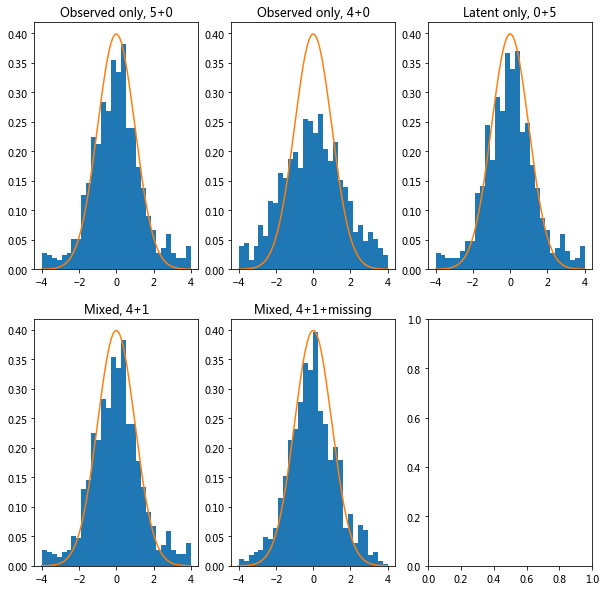

In [10]:
# plot alpha estimates

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,10))

num = 689
    
# B1

est = result0101['alpha_est_B1'][num,:]
se  = result0101['se_B1'][num,:]
alpha_standard = (est-np.mean(est))/se # get the standarized alpha estimate
ax1.hist(alpha_standard, bins = 30,range=(-4,4), density = True)

xp = np.linspace(-4,4,1000)
yp = stats.norm.pdf(xp)

ax1.title.set_text('Observed only, 5+0')
ax1.plot(xp,yp)

# B2

est = result0101['alpha_est_B2'][num,:]
se  = result0101['se_B2'][num,:]
alpha_standard = (est-np.mean(est))/se
ax2.hist(alpha_standard, bins = 30,range=(-4,4), density = True)

xp = np.linspace(-4,4,1000)
yp = stats.norm.pdf(xp)

ax2.title.set_text('Observed only, 4+0')
ax2.plot(xp,yp)

# B3

est = result0101['alpha_est_B3'][num,:]
se  = result0101['se_B3'][num,:]
alpha_standard = (est-np.mean(est))/se
ax3.hist(alpha_standard, bins = 30,range=(-4,4), density = True)

xp = np.linspace(-4,4,1000)
yp = stats.norm.pdf(xp)

ax3.title.set_text('Latent only, 0+5')
ax3.plot(xp,yp)

# B4

est = result0101['alpha_est_B4'][num,:]
se  = result0101['se_B4'][num,:]
alpha_standard = (est-np.mean(est))/se
ax4.hist(alpha_standard, bins = 30,range=(-4,4), density = True)

xp = np.linspace(-4,4,1000)
yp = stats.norm.pdf(xp)

ax4.title.set_text('Mixed, 4+1')
ax4.plot(xp,yp)

# B5

est = result0101['alpha_est_B5'][num,:]
se  = result0101['se_B5'][num,:]
alpha_standard = (est-np.mean(est))/se
ax5.hist(alpha_standard, bins = 30,range=(-4,4), density = True)

xp = np.linspace(-4,4,1000)
yp = stats.norm.pdf(xp)

ax5.title.set_text('Mixed, 4+1+missing')
ax5.plot(xp,yp)

In [ ]:
%%time

# p1 = 0.1, p2 = 0.2

result_0102 = main_simulation_MC(0.1,0.2,1000,240)

In [11]:
# report FDP/aver power/FDN

# retrieve the result from bootstrap for p1,p2 = 0.1, 0.1

result_list = [result0101,result_0102]

for result in result_list:

    print ('FDP %,   ', round(np.mean(result['FDP_B1'])*100, 2), round(np.mean(result['FDP_B2'])*100, 2), 
                     round(np.mean(result['FDP_B3'])*100, 2), round(np.mean(result['FDP_B4'])*100, 2),
                     round(np.mean(result['FDP_BH4'])*100, 2), round(np.mean(result['FDP_BH5'])*100, 2))

    print ('FDP std,  ', round(std(result['FDP_B1'])*100, 2), round(std(result['FDP_B2'])*100, 2), 
                     round(std(result['FDP_B3'])*100, 2), round(std(result['FDP_B4'])*100, 2),
                     round(std(result['FDP_BH4'])*100, 2),round(std(result['FDP_BH5'])*100, 2))

    print ('Average power %, ', round(np.mean(result['ave_pow_B1'])*100, 2), round(np.mean(result['ave_pow_B2'])*100, 2), 
                     round(np.mean(result['ave_pow_B3'])*100, 2), round(np.mean(result['ave_pow_B4'])*100, 2),
                     round(np.mean(result['ave_pow_BH4'])*100, 2),round(np.mean(result['ave_pow_BH5'])*100, 2))

    print ('FDN %,   ', round(np.mean(result['FDN_B1'])*100, 2), round(np.mean(result['FDN_B2'])*100, 2), 
                     round(np.mean(result['FDN_B3'])*100, 2), round(np.mean(result['FDN_B4'])*100, 2),
                     round(np.mean(result['FDN_BH4'])*100, 2),round(np.mean(result['FDN_BH5'])*100, 2))

    print ()

NameError: name 'result_0102' is not defined

| Case | (a) | (b) | (c) | (d) | (e) | (f) | (g) |
|---|---|---|---|---|---|---|---|
||**5+0**|**4+0**|**0+5**|**4+1**|**4+1**|**4+1**|**4+1**|
|Screening||||| Y | Y | Y |
|Missing|||||| Y | Y |
|Bootstrap|||||||Y| 
|**p1 = 0.1, p2 = 0.1**|||||||
||||||||||
|FDP %| 4.65 | 9.76 | 4.59 | 4.64 | 5.41 | 11.73 | 5.43 |
|FDP std| 3.2 | 17.47 | 3.18 | 3.2 | 3.48 | 10.09 | 4.76 |
|Average power %| 61.89 | 50.64 | 61.81 | 61.88 | 62.78 | 46.62 | 37.84 |
|FDN %| 4.08 | 5.25 | 4.09 | 4.08 | 3.99 | 5.65 | 6.45 |
|**p1 = 0.1, p2 = 0.2**|||||||
||||||||||
|FDP %| 4.09 | 6.17 | 4.06 | 4.07 | 4.66 | 6.39 ||
|FDP std| 2.2 | 11.36 | 2.18 | 2.19 | 2.32 | 3.37 ||
|Average power %| 67.21 | 54.52 | 67.26 | 67.21 | 68.17 | 51.8 ||
|FDN %| 7.52 | 10.15 | 7.51 | 7.52 | 7.32 | 10.7 ||